In [2]:
import requests
import json
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

#  We get the data with the API

In [3]:
# Make a get request
response = requests.get("https://coronavirus-tracker-api.herokuapp.com/v2/locations?sources='jhu'&timelines=1")
# Print the status code of the response.
if response.status_code == 200 :
    print("Successful connection")
else :
    print("Connection problem: error " + str(response.status_code))
data = response.json()
total_df = pd.json_normalize(data['latest'])
locations_df = pd.json_normalize(data['locations'])
locations_timeseries_df = pd.json_normalize(data['locations'],max_level=2)
print(total_df)
locations_timeseries_df.columns

Successful connection
   confirmed  deaths  recovered
0    6266192  375559          0


Index(['id', 'country', 'country_code', 'country_population', 'province',
       'last_updated', 'coordinates.latitude', 'coordinates.longitude',
       'latest.confirmed', 'latest.deaths', 'latest.recovered',
       'timelines.confirmed.latest', 'timelines.confirmed.timeline',
       'timelines.deaths.latest', 'timelines.deaths.timeline',
       'timelines.recovered.latest', 'timelines.recovered.timeline'],
      dtype='object')

# Describe the data

In [4]:
locations_timeseries_df.describe()

,id,country_population,latest.confirmed,latest.deaths,latest.recovered,timelines.confirmed.latest,timelines.deaths.latest,timelines.recovered.latest
count,266.000000,2.630000e+02,2.660000e+02,266.000000,266.0,2.660000e+02,266.000000,266.0
mean,132.500000,2.060087e+08,2.355711e+04,1411.875940,0.0,2.355711e+04,1411.875940,0.0
std,76.931788,4.595053e+08,1.233261e+05,7819.009932,0.0,1.233261e+05,7819.009932,0.0
min,0.000000,9.210000e+02,1.000000e+00,0.000000,0.0,1.000000e+00,0.000000,0.0
25%,66.250000,4.841494e+06,1.535000e+02,2.000000,0.0,1.535000e+02,2.000000,0.0
50%,132.500000,1.907769e+07,9.010000e+02,13.000000,0.0,9.010000e+02,13.000000,0.0
75%,198.750000,6.648899e+07,6.213250e+03,139.750000,0.0,6.213250e+03,139.750000,0.0
max,265.000000,1.392730e+09,1.811360e+06,105165.000000,0.0,1.811360e+06,105165.000000,0.0


# We can see a relation between deaths and confirmed cases

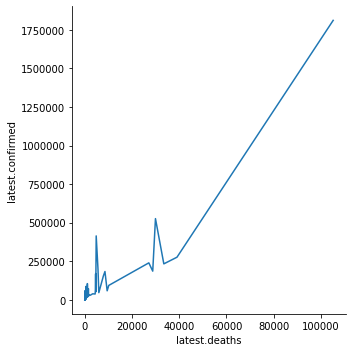

In [5]:
sns.relplot(x="latest.deaths", y="latest.confirmed",kind='line', data=locations_timeseries_df )

In [6]:
covariance = np.cov(locations_timeseries_df['latest.deaths'], locations_timeseries_df['latest.confirmed'])
covariance

array([[6.11369163e+07, 9.01161755e+08],
       [9.01161755e+08, 1.52093390e+10]])

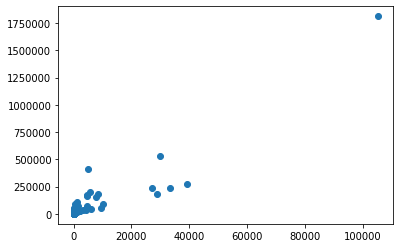

In [7]:
plt.scatter(locations_timeseries_df['latest.deaths'], locations_timeseries_df['latest.confirmed'])

In [8]:
#calculate Pearson's correlation
corr, _ = pearsonr(locations_timeseries_df['latest.deaths'], locations_timeseries_df['latest.confirmed'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.935


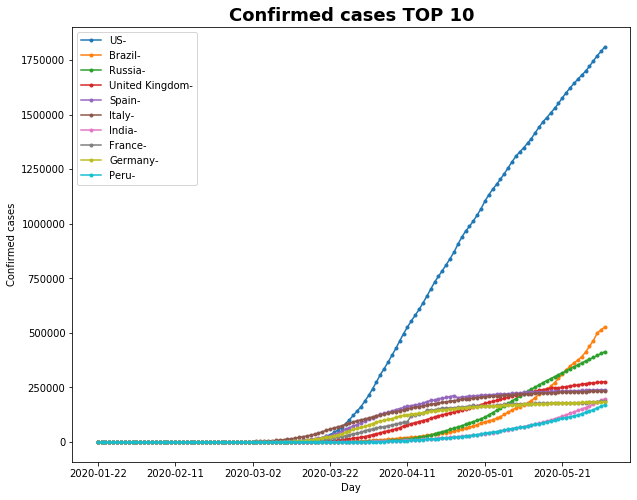

In [9]:
#creating an empy dataframe
total_deathstimeline = pd.DataFrame([])
total_confirmedtimeline = pd.DataFrame([])

#sort by confirmed
total_confirmed_sorted = locations_timeseries_df.sort_values(['latest.confirmed'], ascending=[False])
#sort by deaths
total_deaths_sorted = locations_timeseries_df.sort_values(['latest.deaths'], ascending=[False])

#top 10 by confirmed and deaths
top10_confirmed = total_confirmed_sorted.iloc[0:10]
top10_deaths = total_deaths_sorted.iloc[0:10]

#transform to get the timeline by country for confirmed cases
for index, row in top10_confirmed.iterrows():
    confirmed_timeline=pd.DataFrame.from_dict(row["timelines.confirmed.timeline"],orient='index',columns=[row['country']+"-"+row['province']])
    
    if total_confirmedtimeline.empty :
        total_confirmedtimeline = total_confirmedtimeline.append(confirmed_timeline)
    else :
        total_confirmedtimeline = total_confirmedtimeline.join(confirmed_timeline)

#transform to get the timeline by country for deaths cases
for index, row in top10_deaths.iterrows():
    deaths_timeline = pd.DataFrame.from_dict(row['timelines.deaths.timeline'],orient='index',columns=[row['country']+"-"+row['province']])
    if total_deathstimeline.empty :
        total_deathstimeline = total_deathstimeline.append(deaths_timeline)
    else :
        total_deathstimeline = total_deathstimeline.join(deaths_timeline)

#format for date        
def formatDate(date) :
    new_date = date[0:10]
    return(new_date)        

#aplly format to date
total_deathstimeline['date'] = total_deathstimeline.index
total_deathstimeline.reset_index(drop=True, inplace=True)
total_deathstimeline['date']=total_deathstimeline['date'].apply(formatDate)

total_confirmedtimeline['date'] = total_confirmedtimeline.index
total_confirmedtimeline.reset_index(drop=True, inplace=True)
total_confirmedtimeline['date']=total_confirmedtimeline['date'].apply(formatDate)

#plot 1 - Confirmed cases TOP 10
f1 = plt.figure(1,figsize=(10,8))

plt.title('Confirmed cases TOP 10', fontdict={'fontweight':'bold', 'fontsize': 18})

for country in total_confirmedtimeline:
    if country != 'date':
        plt.plot(total_confirmedtimeline.date, total_confirmedtimeline[country], marker='.', label=country)

plt.xticks(total_confirmedtimeline.date[::20].tolist())

plt.xlabel('Day')
plt.ylabel('Confirmed cases')

plt.legend()

plt.savefig('confirmed cases.png', dpi=300)

plt.show() 




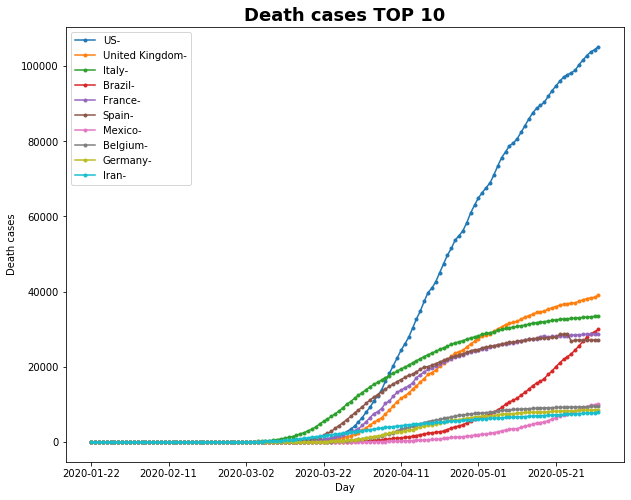

In [10]:
#plot 2 - Death cases TOP 10
f2 = plt.figure(2,figsize=(10,8))

plt.title('Death cases TOP 10', fontdict={'fontweight':'bold', 'fontsize': 18})

for country in total_deathstimeline:
    if country != 'date':
        plt.plot(total_deathstimeline.date, total_deathstimeline[country], marker='.', label=country)

plt.xticks(total_deathstimeline.date[::20].tolist())

plt.xlabel('Day')
plt.ylabel('Death cases')

plt.legend()

plt.savefig('death cases.png', dpi=300)

plt.show() 

# We can see that US has the most cases and deaths in relation to other countries

While there are many factors at play when comparing how countries have fared in the coronavirus pandemic, public health experts say Trump’s explanation left out a key factor: The U.S. has so many cases because it was initially slow to respond to the outbreak and ramp up testing and other containment tools.

Experts say the U.S. is not alone in being hit hard by the virus because of a slow response, and it’s not off-the-charts worse when comparing on a per-person basis. Rather, the U.S. is similar to Italy, Spain and the United Kingdom — countries that have also been dealt a heavy blow from the virus.

Source: https://thehill.com/

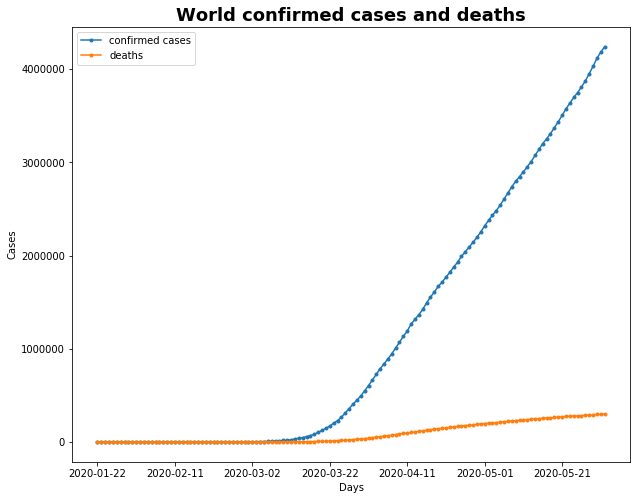

In [11]:
#plot 3 - World confirmed cases and deaths
total_confirmedtimeline['total'] = total_confirmedtimeline.sum(axis = 1, skipna = True)
total_deathstimeline['total'] = total_deathstimeline.sum(axis = 1, skipna = True)

f3 = plt.figure(3,figsize=(10,8))

plt.title('World confirmed cases and deaths', fontdict={'fontweight':'bold', 'fontsize': 18})

plt.plot(total_confirmedtimeline.date, total_confirmedtimeline['total'], marker='.', label='confirmed cases')  
plt.plot(total_deathstimeline.date, total_deathstimeline['total'], marker='.', label='deaths')

plt.xticks(total_confirmedtimeline.date[::20].tolist())

plt.xlabel('Days')
plt.ylabel('Cases')

plt.savefig('world confirmed and deaths cases.png', dpi=300)

plt.legend()
    
plt.show()    

total_confirmedtimeline.to_excel("confirmed_timeline.xlsx","data")
total_deathstimeline.to_excel("deaths_timeline.xlsx","data")

In [12]:
#calculate world poblation
total_df['population'] = locations_timeseries_df['country_population'].sum()
#calculate world fatality for covid
total_df['fatality'] = round(total_df['deaths']/total_df['confirmed'] * 100, 2)

print("Tasa de letalidad")
total_df


Tasa de letalidad


,confirmed,deaths,recovered,population,fatality
0,6266192,375559,0,5.418030e+10,5.99


In [13]:
#calculate mortality by country
locations_timeseries_df['fatality'] = locations_timeseries_df['latest.deaths']/locations_timeseries_df['latest.confirmed'] * 100

confirmed1000 = locations_timeseries_df['latest.confirmed'] >= 1000
locations_confirmed1000 = locations_timeseries_df[confirmed1000]
locations_sortedby_fatality = locations_confirmed1000.sort_values(['fatality'], ascending=[False])
top10_fatality = locations_sortedby_fatality.iloc[0:10,[0,1,2,3,4,8,9,17]]
top10_fatality['fatality']= round(top10_fatality['fatality'],2)
top10_fatality = top10_fatality.drop(['id'], axis=1)
print("Tasa de letalidad por país")
top10_fatality.style.background_gradient(cmap="Blues")

Tasa de letalidad por país


,country,country_code,country_population,province,latest.confirmed,latest.deaths,fatality
23,Belgium,BE,11422068.000000,,58517,9486,16.210000
116,France,FR,66987244.000000,,185952,28779,15.480000
137,Italy,IT,60431283.000000,,233197,33475,14.350000
223,United Kingdom,GB,66488991.000000,,276332,39045,14.130000
129,Hungary,HU,9768785.000000,,3892,527,13.540000
169,Netherlands,NL,17231017.000000,,46545,5962,12.810000
205,Sweden,SE,10183175.000000,,37814,4403,11.640000
201,Spain,ES,46723749.000000,,239638,27127,11.320000
158,Mexico,MX,126190788.000000,,93435,10167,10.880000
44,Canada,CA,37058856.000000,Quebec,51354,4661,9.080000


# Belgium has the highest fatality rate.

Belgian officials say they are counting in a way that no other country in the world is currently doing: counting deaths in hospitals and care homes, but including deaths in care homes that are suspected, not confirmed, as Covid-19 cases.
Some 16% of deaths in care homes were tested positive for coronavirus. The rest are suspected.
That means more than 3,500 deaths have been counted as caused by Covid-19, but not confirmed.

Source: BBC.com

## We could analyse more variables if we could have more data about the outbreak like number of people hospitalized, number of people recovered, weather data of each country